# CSCN8010 - Lab 3
Erica Holden, 5490685

## Loading the Data

Initially we load the dogs vs cats data, it has been obtained from Kaggle but there are 25,000 images. For our purposes we will only use 5,000.

In [2]:
import os, shutil
from pathlib import Path

original_dir = Path(".") / "data" / "dogs_vs_cats" / "train"
new_base_dir = Path(".") / "data" / "dogs_vs_cats_small"

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            print("Copying:", src, "->", dst)
            if not src.exists():
                print("⚠️ Source file not found:", src)
            else:
                shutil.copyfile(src=src, dst=dst)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

Copying: data\dogs_vs_cats\train\cat.0.jpg -> data\dogs_vs_cats_small\train\cat\cat.0.jpg
Copying: data\dogs_vs_cats\train\cat.1.jpg -> data\dogs_vs_cats_small\train\cat\cat.1.jpg
Copying: data\dogs_vs_cats\train\cat.2.jpg -> data\dogs_vs_cats_small\train\cat\cat.2.jpg
Copying: data\dogs_vs_cats\train\cat.3.jpg -> data\dogs_vs_cats_small\train\cat\cat.3.jpg
Copying: data\dogs_vs_cats\train\cat.4.jpg -> data\dogs_vs_cats_small\train\cat\cat.4.jpg
Copying: data\dogs_vs_cats\train\cat.5.jpg -> data\dogs_vs_cats_small\train\cat\cat.5.jpg
Copying: data\dogs_vs_cats\train\cat.6.jpg -> data\dogs_vs_cats_small\train\cat\cat.6.jpg
Copying: data\dogs_vs_cats\train\cat.7.jpg -> data\dogs_vs_cats_small\train\cat\cat.7.jpg
Copying: data\dogs_vs_cats\train\cat.8.jpg -> data\dogs_vs_cats_small\train\cat\cat.8.jpg
Copying: data\dogs_vs_cats\train\cat.9.jpg -> data\dogs_vs_cats_small\train\cat\cat.9.jpg
Copying: data\dogs_vs_cats\train\cat.10.jpg -> data\dogs_vs_cats_small\train\cat\cat.10.jpg
Copying:

## Checking for bad images

We want to check that there are no corrupted images in the dataset, using the code below.

In [3]:
from PIL import Image
from pathlib import Path

bad_files = []
for file in Path(new_base_dir).rglob("*.jpg"):
    try:
        with Image.open(file) as img:
            img.load()  # force loading pixel data
    except Exception as e:
        bad_files.append((file, str(e)))

print(f"Found {len(bad_files)} problematic images.")
for file, error in bad_files[:5]:  # Show just first 5 errors
    print(f"{file}: {error}")


Found 0 problematic images.


## Checking for grayscale images

Above we can see there are 0 problematic images, but what if some are grayscale? We want to check if any of the images are grayscale instead of RGB, using the code below.

In [4]:
from collections import Counter
channels = []

for file in new_base_dir.rglob("*.jpg"):
    with Image.open(file) as img:
        channels.append(len(img.getbands()))  # 1 = grayscale, 3 = RGB

print("Channel counts:", Counter(channels))

Channel counts: Counter({3: 5000})


## Class distribution bar plot

As above, all the images have 3 channels - RGB - and are not grayscale, making them equivalent. Let's explore the distribution of cat and dog images in the training set, using a bar plot.

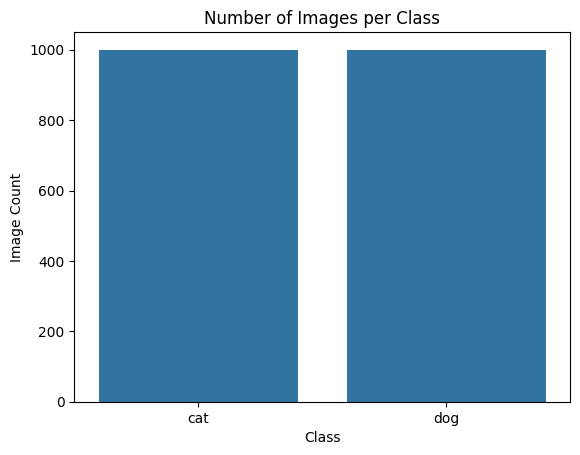

In [5]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = new_base_dir / "train"

class_counts = {}
for folder in base_dir.iterdir():
    if folder.is_dir():
        # Count all jpg, jpeg, and png files in the folder
        image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.jpeg")) + list(folder.glob("*.png"))
        class_counts[folder.name] = len(image_files)

df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

sns.barplot(data=df, x="Class", y="Count")
plt.title("Number of Images per Class")
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.show()


## Loading the datasets for Tensorflow

Now we can load the datasets for Tensorflow, and create a custom convolutional neural network (CNN) using the Keras functional API.

In [10]:
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

data_folder = pathlib.Path('./data/dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## Configure the model for training

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Train the model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [15]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

Num GPUs Available: 0
